In [1]:
from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from astropy.io import fits
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion
import shapely
from shapely.geometry import Polygon, Point

def is_point_inside_bounding_area(bounding_points, point_to_check):
    # Create a Polygon from the bounding points
    polygon = Polygon(bounding_points)
    
    # Create a Point object from the point to check
    point = Point(point_to_check)
    
    # Check if the point is within the polygon
    return polygon.contains(point)

/media/rd1/kwillis/kevlib_dev/src/kevlib/common_imports.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange  # 231010


---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-06 06:53 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [2]:
import numpy as np

def find_patterns(image):
    target_value = 268435456
    """
    Find specific patterns in the image and return a binary mask.

    Patterns include:
    - 2x2 squares
    - Diagonal pairs of pixels (top-left to bottom-right, top-right to bottom-left)
    - Stacks of two pixels (vertically or horizontally)

    Parameters:
    - image (np.ndarray): The input image array.
    - target_value (int): The pixel value to look for in the patterns.

    Returns:
    - np.ndarray: A binary mask indicating where the patterns are found.
    """
    height, width = image.shape
    mask_image = np.zeros((height, width), dtype=int)

    for y in range(height - 1):
        for x in range(width - 1):
            # Check for 2x2 squares
            if (image[y, x] == target_value and
                image[y, x + 1] == target_value and
                image[y + 1, x] == target_value and
                image[y + 1, x + 1] == target_value):
                
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1
                mask_image[y + 1, x + 1] = 1

            # Check for diagonal patterns (top-left to bottom-right)
            if (image[y, x] == target_value and
                image[y + 1, x + 1] == target_value):
                mask_image[y, x] = 1
                mask_image[y + 1, x + 1] = 1

            # Check for diagonal patterns (top-right to bottom-left)
            if (image[y, x + 1] == target_value and
                image[y + 1, x] == target_value):
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1

            # Check for vertical stacks of two pixels
            if image[y, x] == target_value and image[y + 1, x] == target_value:
                mask_image[y, x] = 1
                mask_image[y + 1, x] = 1

            # Check for horizontal stacks of two pixels
            if image[y, x] == target_value and image[y, x + 1] == target_value:
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1

    # Check for vertical stacks in the last column
    for y in range(height - 1):
        if image[y, width - 1] == target_value and image[y + 1, width - 1] == target_value:
            mask_image[y, width - 1] = 1
            mask_image[y + 1, width - 1] = 1

    # Check for horizontal stacks in the last row
    for x in range(width - 1):
        if image[height - 1, x] == target_value and image[height - 1, x + 1] == target_value:
            mask_image[height - 1, x] = 1
            mask_image[height - 1, x + 1] = 1

    return mask_image


def remove_artifacts(mask, img):
    
    original_img = np.copy(img)
    
    bm = find_patterns(mask)
    c_obj_map = binary_dilation(bm, iterations=4)
    
    img[c_obj_map] = np.nan
    non_nan_pixels = img[~np.isnan(img)]
    background_noise = np.std(non_nan_pixels)
    
    nan_mask = np.isnan(img)
    
    img[nan_mask] = np.random.normal(0, background_noise, size=nan_mask.sum())
    
    if (original_img==img).all():
        corrected = False;
    else:
        corrected= True
    return img, corrected

In [3]:
search_frames = []
mjds = []

query = "https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?catalog=neowiser_p1bm_frm&spatial=None&outfmt=1&constraints="
query += "(ra1 > 56 and ra1 < 61) and (dec1 > 19 and dec1 < 24) and ( mjd_obs > 59810 and mjd_obs <= 59830) and band=2"

url = urllib.parse.quote(query, safe=':/?=&()>')
download_tbl = astro_ascii.read(url)
download_tbl = download_tbl.to_pandas()

print(len(download_tbl))
print(download_tbl)

for i in range(len(download_tbl)):

    row = download_tbl.iloc[i]
    id = [row["frame_num"], row["scan_id"], row["scangrp"], row["mjd_obs"], row["ra1"], row["dec1"], row["ra2"], row["dec2"], row["ra3"], row["dec3"], row["ra4"], row["dec4"]]
    search_frames.append(id)

483
    scan_id scangrp  frame_num  band  naxis  naxis1  naxis2      wrelease  \
0    42330r      0r        138     2      2    1016    1016  release-v7.5   
1    42334r      4r        138     2      2    1016    1016  release-v7.5   
2    42334r      4r        139     2      2    1016    1016  release-v7.5   
3    42338r      8r         98     2      2    1016    1016  release-v7.5   
4    42338r      8r         99     2      2    1016    1016  release-v7.5   
..      ...     ...        ...   ...    ...     ...     ...           ...   
478  42366r      6r        106     2      2    1016    1016  release-v7.5   
479  42366r      6r        107     2      2    1016    1016  release-v7.5   
480  42366r      6r        108     2      2    1016    1016  release-v7.5   
481  42366r      6r        109     2      2    1016    1016  release-v7.5   
482  42366r      6r        110     2      2    1016    1016  release-v7.5   

     crpix1  crpix2  ...     cd1_1     cd1_2     cd2_1     cd2_2  debga

In [43]:
# all_ras = np.array([frame[4] for frame in search_frames])
# all_decs = np.array([frame[5] for frame in search_frames])

# plt.figure()
# plt.plot(all_ras[0:], all_decs[0:], ".k")
# plt.plot(all_ras[480:500], all_decs[480:500], ".b")

In [4]:
plt.close()

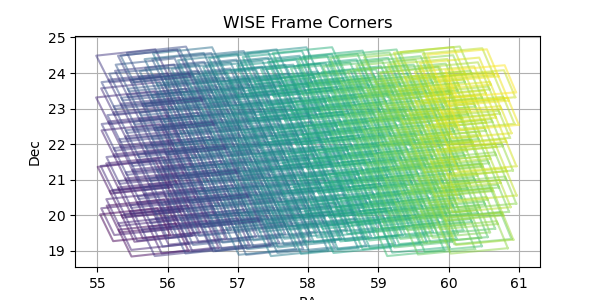

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

# Extract all MJDs from search_frames for normalization
all_mjds = np.array([frame[3] for frame in search_frames])

# Normalize MJD values to range [0, 1]
norm = Normalize(vmin=all_mjds.min(), vmax=all_mjds.max())
scaler = viridis  # Select the colormap

# Create the plot
plt.figure(figsize=(6, 3))

for id in search_frames[0:]:
    frame_num = id[0]
    ra = id[4:12:2]  # Extract RA coordinates
    dec = id[5:12:2]  # Extract Dec coordinates
    mjd = id[3]

    # Get the color for the current MJD
    color = scaler(norm(mjd))

    # Plot the frame using the MJD-based color
    plt.plot(ra + [ra[0]], dec + [dec[0]], label=f'Frame {frame_num}', c=color, alpha=0.5)

# Setting the plot labels and title
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('WISE Frame Corners')
# plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=scaler), label='MJD')
plt.grid(True)
plt.show()

(array([ 23.,  98., 118., 109., 135.]),
 array([59813., 59814., 59815., 59816., 59817., 59818.]),
 <BarContainer object of 5 artists>)

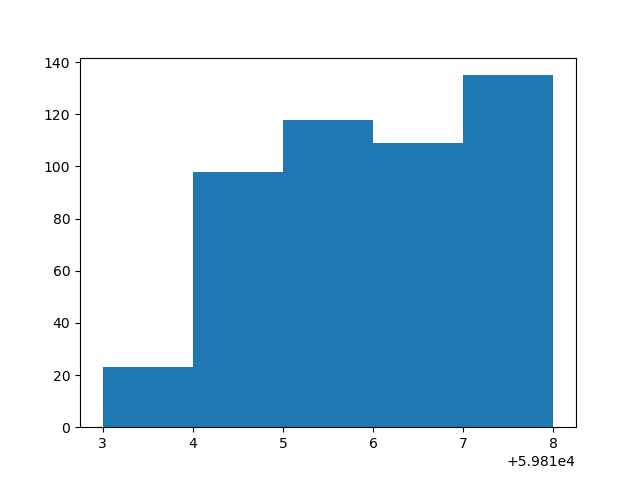

In [6]:
mjds = [int(s[3]) for s in search_frames]
plt.figure()
plt.hist(mjds, bins=5)
# plt.close()

In [9]:
def get_single_file_url(scan_id, scangrp, frame_num):

    irsa_url = "%s/%s/%03d/" % (scangrp, scan_id, frame_num)

    filename = f"{scan_id:s}{frame_num:03d}-w2-int-1b.fits"

    irsa_url = f'https://irsa.ipac.caltech.edu/ibe/data/wise/neowiser/p1bm_frm/{irsa_url}/{filename}'
    
    return irsa_url

#----------------------------------------------------------------------------------------------------------------------------

def URL_list(megalist):
    urllist = []
    for i in megalist:
        url = get_single_file_url(i[1], i[2], int(i[0]))
        urllist.append(url)
    return urllist

urllist = URL_list(search_frames)

#----------------------------------------------------------------------------------------------------------------------------

def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    # im_sg_br / s_rms - > noise normalized
    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_coadd_br = im_coadd - c_bkg # Bkg removal
    
    c_obj_map = im_coadd_br > 0.5 # Tuneable threshold
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    # Fill single with NaN where objects found in the coadd
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cpu',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------
    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3*s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            norm_kwargs=dict(min_cut=-1, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single


import numpy as np
from PIL import Image

def grid_image(image_array, square_size):
    corners = []
    # Convert the image array to a PIL image
    image = Image.fromarray(image_array)

    # Get the size of the original image
    width, height = image.size

    # Calculate the number of squares in both dimensions
    num_squares_x = width // square_size
    num_squares_y = height // square_size

    squares = []
    # Loop through the image and crop it into smaller squares
    for i in range(num_squares_x):
        for j in range(num_squares_y):
            left = i * square_size
            upper = j * square_size
            right = (i + 1) * square_size
            lower = (j + 1) * square_size

            # Crop the square
            square = image.crop((left, upper, right, lower))
            # if left == 0:
            #     print(left, upper, right, lower)
            
            # Convert the square to a NumPy array and append to the list
            square_array = np.array(square)
            squares.append(square_array)

            # midpt = midpoint(left, upper, right, lower)
            corners.append([left,upper])
            # print("corner: ", left, upper)

    return squares, corners

In [10]:
import numpy as np
from PIL import Image

def grid_image(image_array, square_size):
    corners = []
    # Convert the image array to a PIL image
    image = Image.fromarray(image_array)

    # Get the size of the original image
    width, height = image.size

    # Calculate the number of squares in both dimensions
    num_squares_x = width // square_size
    num_squares_y = height // square_size

    squares = []
    # Loop through the image and crop it into smaller squares
    for i in range(num_squares_x):
        for j in range(num_squares_y):
            left = i * square_size
            upper = j * square_size
            right = (i + 1) * square_size
            lower = (j + 1) * square_size

            # Crop the square
            square = image.crop((left, upper, right, lower))
            # if left == 0:
            #     print(left, upper, right, lower)
            
            # Convert the square to a NumPy array and append to the list
            square_array = np.array(square)
            squares.append(square_array)

            # midpt = midpoint(left, upper, right, lower)
            corners.append([left,upper])
            # print("corner: ", left, upper)

    return squares, corners

# images = np.ones((len(search_frames), 1016, 1016), dtype=np.uint8)

# all_corners = []
# for img in images:
#     _, corners = grid_image(img, 15)
#     all_corners.append(corners)

# print("Processed corners for all images")

In [11]:
def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_coadd_br = im_coadd - c_bkg # Bkg removal
    
    c_obj_map = im_coadd_br > 0.5 # Tuneable threshold
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    # Fill single with NaN where objects found in the coadd
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cpu',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3 * s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_norm, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            # norm_kwargs=dict(min_cut=-100, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single


In [12]:
len(urllist)

483

In [13]:
from kevlib.utils.io import mmcreate, mmload

grids = []
topcorners = []
coadds = []
bitmasks = []
singles = []

for i in tqdm(range(len(urllist[200:312]))): 
    
    print("On frame " , i)
    
    m, coadd, single = maskImage(urllist[i])
    
    squares, corners = grid_image(m, square_size=15)

    bitmask_url = urllist[i][:87] + "w2-msk-1b.fits.gz"
    bmask = fits.open(bitmask_url)
    bmask = bmask[0].data
    b_grid, _ = grid_image(bmask, 15)

    grids.append(squares)
    maxes = [np.max(s) for s in squares]

    print(maxes[10])
    if 0 in maxes:
        print("image has zeros only. stopped.")
        break
        
    bitmasks.append(b_grid)

print("finished main loop")



  0%|          | 0/112 [00:00<?, ?it/s]

On frame  0
0.7309276
On frame  1
0.5863493
On frame  2
0.6500638
On frame  3
0.78466386
On frame  4
0.5008617
On frame  5
0.7847713
On frame  6
0.6496623
On frame  7
0.5861606
On frame  8
0.48565453
On frame  9
1.4329208
On frame  10
0.7316824
On frame  11
0.5826046
On frame  12
0.7671907
On frame  13
0.5446405
On frame  14
0.7307763
On frame  15
0.4541785
On frame  16
0.72274417
On frame  17
0.73835444
On frame  18
0.7815689
On frame  19
0.6281759
On frame  20
0.71579695
On frame  21
0.86713326
On frame  22
0.74223626
On frame  23
0.47766322
On frame  24
0.84692883
On frame  25
0.640027
On frame  26
0.5258839
On frame  27
0.68673974
On frame  28
0.79148746
On frame  29
0.88585573
On frame  30
0.52853364
On frame  31
0.7403363
On frame  32
1.0527586
On frame  33
0.65649277
On frame  34
0.5642073
On frame  35
0.53037286
On frame  36
0.49461812
On frame  37
0.6927493
On frame  38
1.887595
On frame  39
0.6033038
On frame  40
0.6805053
On frame  41
0.57165104
On frame  42
0.5702233
On fra

In [17]:
all_urls = []
for i in urllist:
    all_urls.append(i)

imgs = [i for a in grids for i in a]
bitmasks_g = [i for a in bitmasks for i in a]

print("started creating npy files")

dep = mmcreate("./TrainingData/true_S1_shifted_initial_bkgs_200_312_p2.npy", dtype=float, shape=(len(imgs), 15, 15), fill_value=0)
dep.flush()

bit = mmcreate("./TrainingData/true_S1_shifted_bitmasks_bkgs_200_312_p2.npy", dtype=float, shape=(len(imgs), 15, 15), fill_value=0)
bit.flush()

finaldep = mmcreate("./TrainingData/true_S1_shifted_FINAL_bkgs_200_312_p2.npy", dtype=float, shape=(len(imgs), 15, 15), fill_value=0)
finaldep.flush()

print("starting to save data")

for i in tqdm(range(len(dep[280000:500000]))):
    dep[i, :, :] = imgs[i]
    bit[i, :, :] = bitmasks_g[i]
    
    im, c = remove_artifacts(np.array(bit[i]), dep[i])
    finaldep[i, :, :] = im
    if (np.max(im) == 0.0):
        print("empty image detected")
        break
    
    dep.flush()
    bit.flush()
    finaldep.flush()

started creating npy files
starting to save data


  0%|          | 0/220000 [00:00<?, ?it/s]

# Implant Synthetic Images

In [19]:
t_bkgs = np.load("./TrainingData/TrueSet/true_S1_shifted_FINAL_bkgs_200_312.npy")
t_bkgs += np.load("./TrainingData/TrueSet/true_S1_shifted_FINAL_bkgs_200_312_p2.npy")

t_bkgs.shape

(502768, 15, 15)

In [21]:
np.save("./TrainingData/TrueSet/True_500k_background_images_S1_shifted", t_bkgs[0:500000])